<a href="https://colab.research.google.com/github/Timure228/LSTM_Based_Text_Generator/blob/main/LSTM_Gen_Chars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Chars Generator

In [3]:
import torch
from torch import nn
from torch.nn import RNN, LSTM, Dropout

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import regex
import string

import numpy as np

import requests /content/sample_data

In [122]:
FILE = "lstb.txt"

request = requests.get("https://raw.githubusercontent.com/Timure228/LSTM_Based_Text_Generator/refs/heads/main/lstb.txt")

with open("/content/" + FILE, "wb") as f:
  f.write(request.content)


with open("/content/" + FILE, "r") as f:
  lines_amount = f.read().count("\n") + 1

lines_amount

7836

In [139]:
translator = str.maketrans('', '', string.punctuation)
n_translator = str.maketrans('', '', '\nèàôêé£')

In [173]:
import re

with open(FILE, "r") as f:
  text = f.read()
  # text = text[:int(len(text)*0.5) + 1]
  text = text.strip().translate(translator).lower()
  text = text.translate(n_translator)
  text = " ".join(text.split())

# print(f"Before: {len(text)}")

# text = re.sub('\)', '',text)
# text = re.sub('\(', '',text)

# for pattern in set(re.findall('<unk>', text)):
#   text = re.sub(pattern, '', text)

# print(f"After: {len(text)}")

In [142]:
train_text = text[:int(len(text)*0.8)]
test_text = text[int(len(text)*0.8):]

In [175]:
# Tokenize
tokens = []
for i in text:
  tokens.append(i)

print("word", max(set(tokens), key=tokens.count))

tokens = list(set(tokens))
vocab_size = len(tokens)
sorted(tokens), vocab_size

word  


([' ',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z'],
 37)

In [176]:
indx_to_token = {indx: token for indx, token in enumerate(tokens)}
token_to_indx = {token: indx for indx, token in enumerate(tokens)}

In [177]:
# Create encode and decode function
def encode(arr: list, token_to_indx=token_to_indx):
  for i in arr:
    for j in range(len(i)):
      i[j] = token_to_indx[i[j]]
  return arr

def decode(arr: list, indx_to_token=indx_to_token):
  for i in arr:
    for j in range(len(i)):
      i[j] = indx_to_token[i[j]]
  return arr

In [180]:
SEQ_LENGTH = 30

def create_sequence(X: list, y: list, text: str, SEQ_LENGTH = SEQ_LENGTH, STEP=1):
  for i in range(0, len(text)- SEQ_LENGTH, STEP):
    chars = []
    for j in range(i, i + SEQ_LENGTH):
      chars.append(text[j])
    X.append(chars)

    y.append([text[i+SEQ_LENGTH]])
  return X, y

In [183]:
# Creating the sequences
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=SEQ_LENGTH, STEP=3)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=SEQ_LENGTH, STEP=3)

X_test[1], y_test[1]

([' ',
  ' ',
  ' ',
  ' ',
  'a',
  'n',
  'd',
  ' ',
  'o',
  'w',
  'e',
  'n',
  ' ',
  'w',
  'e',
  'r',
  'e',
  ' ',
  's',
  'i',
  'n',
  'g',
  'i',
  'n',
  'g',
  ' ',
  's',
  'n',
  'a',
  't'],
 ['c'])

In [184]:
# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

In [185]:
X_test = encode(X_test)
y_test = encode(y_test)

In [189]:
# Padding X
X_train_padded = pad_sequences(X_train, maxlen=SEQ_LENGTH, padding='post', value=0)  # 'post' means pad at the end of each sequence

X_test_padded = pad_sequences(X_test, maxlen=SEQ_LENGTH, padding='post', value=0)

In [190]:
# Converting X and y to categorical vectors
X_train_cat = to_categorical(X_train_padded, num_classes=vocab_size)
y_train_cat = to_categorical(y_train, num_classes=vocab_size)

In [191]:
X_test_cat = to_categorical(X_test_padded, num_classes=vocab_size)
y_test_cat = to_categorical(y_test, num_classes=vocab_size)

In [153]:
# Check the ranks of X and y
print(f"X Rank: {tf.rank(X_train_cat)} | y Rank: {tf.rank(y_train_cat)}")
print(f"X Shape: {X_train_cat.shape} | y shape: {y_train_cat.shape}")
print(f"X Type: {type(X_train_cat)} | y Type: {type(y_train_cat)}")

X Rank: 3 | y Rank: 2
X Shape: (301991, 10, 37) | y shape: (301991, 37)
X Type: <class 'numpy.ndarray'> | y Type: <class 'numpy.ndarray'>


In [192]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Input

# TensorFlow Based

In [193]:
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, vocab_size)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [194]:
history = model.fit(x=X_train_cat, y=y_train_cat, batch_size=128, shuffle=True, epochs=2, verbose=1)

Epoch 1/2
787/787 ━━━━━━━━━━━━━━━━━━━━ 115s 140ms/step - accuracy: 0.2295 - loss: 2.9186
Epoch 2/2
787/787 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - accuracy: 0.3225 - loss: 2.3088


In [195]:
model.save_weights("/content/char_lstm.weights.h5")

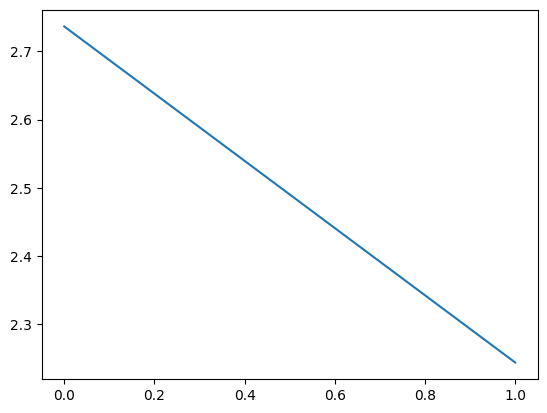

In [196]:
# Plot the Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["loss"])

In [197]:
# Model structure
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 30, 128)             │          84,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 37)                  │           2,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,897 (1.61 MB)

 Trainable params: 140,965 (550.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 281,932 (1.08 MB)

In [216]:
input_string = [["say my name"]]

def convert(string):
  input_string = [i for i in string[0][0]]
  input_string_arr = [token_to_indx[i] for i in input_string]
  input_string_arr = pad_sequences([input_string_arr], maxlen=10, padding="pre", value=0)
  input_string_arr = tf.keras.utils.to_categorical(input_string_arr, num_classes=vocab_size)
  return input_string_arr

input_string_arr = convert(input_string)

y_preds = model.predict(input_string_arr)
print(y_preds, y_preds.shape)

probabilities = tf.argmax(y_preds, axis=1)
print(probabilities)
input_string[0].append(indx_to_token[int(probabilities)])
print(input_string)
print("".join(input_string[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[4.5764000e-06 1.2969830e-06 1.1927511e-04 3.7182530e-03 2.0377132e-07
  1.3705739e-02 9.9295961e-05 7.3981801e-07 9.7443135e-03 1.5873086e-07
  4.0342647e-07 3.9137341e-04 5.5354466e-03 7.7381730e-01 6.0428365e-04
  4.8295703e-07 7.0270281e-03 5.6959234e-02 1.1641126e-03 5.0839990e-06
  2.3370557e-02 9.1809937e-07 1.3977786e-02 9.2658453e-08 1.3274351e-02
  4.3536190e-02 3.1158465e-04 6.1523996e-04 1.5587199e-03 2.0858974e-03
  1.2687467e-02 3.1867647e-03 1.2224369e-02 1.8342872e-07 1.9466650e-07
  2.7103157e-04 9.7149488e-08]] (1, 37)
tf.Tensor([13], shape=(1,), dtype=int64)
[['say my name the', ' ']]
say my name the 


In [199]:
def sort(ran, y_preds):
  arr = []
  for i in range(ran):
    p = tf.argmax(y_preds, axis=1)
    arr.append(p)
    y_preds[0][p] = 0
  return arr

In [209]:
import random

loop_string = [["say my name"]]
arr_input = convert(loop_string)

def predict_loop(string_input, arr_input, output_length, creativity=1):
  for _ in range(output_length):
    y_preds = model.predict(arr_input)

    labels = sort(creativity, y_preds)
    label = labels[random.randint(0, creativity - 1)]

    predicted_word = indx_to_token[int(label)]
    string_input[0].append(predicted_word)
    string_input = [["".join(string_input[0])]]

    new_string = [[string_input[0][0][i + 1:]]]
    print(new_string)

    arr_input = convert(new_string)

  return string_input[0][0]


In [208]:
predict_loop(loop_string, arr_input, 50, creativity=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[['ay my name']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[['y my named']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[' my named ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[['my named t']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[['y named to']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[' named to ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[['named to s']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[['amed to sa']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[['med to sat']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[['ed to sath']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[['d to sathe']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[' to sathe ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[['to sathe t']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[['o sathe to']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[' sathe to ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[['sathe to s']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[['athe to sa']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[['the to san']]
1/1 ━━━━━━

'say my named to sathe to sand and the   se sathe tore than t'

In [ ]:
# Evaluating the model
model.evaluate(X_test_cat, y_test_cat)

In [70]:
import sklearn as sk

In [78]:
sk.metrics.recall_score(y_test_cat, model.predict(X_test_cat))

2409/2409 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets